<a href="https://colab.research.google.com/github/GilSasson/KeepMoving/blob/main/LSTM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A classic LSTM example about the number of bikes rented in London.
Also discussed at: 

https://medium.com/@nutanbhogendrasharma/tensorflow-demand-prediction-with-london-bike-sharing-dataset-3436ac12f230

and 

https://github.com/shakibyzn/London-bike-sharing-time-series-analysis/blob/master/bike_sharing_analysis_using_lstm_model.ipynb


In [151]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [152]:
url = 'https://raw.githubusercontent.com/GilSasson/KeepMoving/main/lidar_test.csv'
df =pd.read_csv(url,  parse_dates=['time'], index_col='time') 

In [153]:
df.head()

,distance_z,velocity_z,dist_from_lidar,almost_fall
time,,,,
2.886151,2.405723,-1.084957,3.5,0
3.023319,2.398088,-0.545561,3.5,0
3.114092,2.393277,-0.379287,3.5,0
3.188361,2.383059,-1.503750,3.5,0
3.319973,2.375078,-0.806650,3.5,0


In [154]:
df.tail()

,distance_z,velocity_z,dist_from_lidar,almost_fall
time,,,,
1264.591417,1.259751,0.085940,3.5,0
1264.689163,1.260624,0.145224,3.5,0
1264.786910,1.261609,0.096537,3.5,0
1264.884656,1.263149,0.090116,3.5,0
1264.982402,1.263741,0.043488,3.5,0


In [155]:
data = df.iloc[::-1]
df = df.append(data)

In [156]:
# plt.figure(figsize=(12,6))
# sns.lineplot(x=df.index, y="almost_fall", data=df)

Now, split the data into train / test.

In [157]:
train_size = int(len(df) * 0.5)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)


(12839, 4) (12839, 4)


Normalize the values before Gradient Descent:

In [158]:
from sklearn.preprocessing import RobustScaler
pd.options.mode.chained_assignment = None

f_columns = ['distance_z', 'velocity_z', 'dist_from_lidar']

f_transformer = RobustScaler()
almost_fall_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
almost_fall_transformer = almost_fall_transformer.fit(train[['almost_fall']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['almost_fall'] = almost_fall_transformer.transform(train[['almost_fall']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['almost_fall'] = almost_fall_transformer.transform(test[['almost_fall']])

This is the trickiest part-- note that the dataset that is created is a time series with time_steps time-steps.

In [159]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [160]:
time_steps = 10
f_columns = ['distance_z', 'velocity_z', 'dist_from_lidar']
train_c = train[f_columns]
test_c = test[f_columns]

X_train, y_train = create_dataset(train_c, train.almost_fall, time_steps)
X_test, y_test = create_dataset(test_c, test.almost_fall, time_steps)

print(X_train.shape, y_train.shape)

(12829, 10, 3) (12829,)


In [161]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=256, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mse', optimizer='adam', metrics=['acc'])

In [162]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=16, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
722/722 [==============================] - 8s 7ms/step - loss: 0.0832 - acc: 0.9705 - val_loss: 0.1279 - val_acc: 0.9564
Epoch 2/30
722/722 [==============================] - 4s 6ms/step - loss: 0.0323 - acc: 0.9729 - val_loss: 0.0438 - val_acc: 0.9595
Epoch 3/30
722/722 [==============================] - 4s 6ms/step - loss: 0.0226 - acc: 0.9760 - val_loss: 0.0531 - val_acc: 0.9571
Epoch 4/30
722/722 [==============================] - 4s 6ms/step - loss: 0.0206 - acc: 0.9758 - val_loss: 0.0435 - val_acc: 0.9571
Epoch 5/30
722/722 [==============================] - 4s 6ms/step - loss: 0.0206 - acc: 0.9781 - val_loss: 0.0502 - val_acc: 0.9564
Epoch 6/30
722/722 [==============================] - 4s 6ms/step - loss: 0.0201 - acc: 0.9777 - val_loss: 0.0456 - val_acc: 0.9587
Epoch 7/30
722/722 [==============================] - 4s 6ms/step - loss: 0.0190 - acc: 0.9776 - val_loss: 0.0356 - val_acc: 0.9602
Epoch 8/30
722/722 [==============================] - 5s 7ms/step - loss: 0.

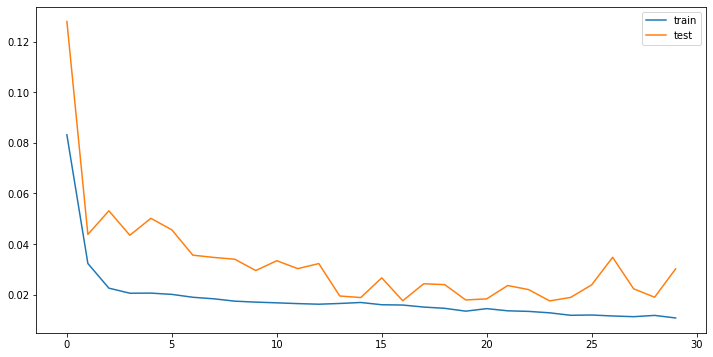

In [163]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()

In [164]:
y_pred = model.predict(X_test)

y_test_inv = almost_fall_transformer.inverse_transform(y_test.reshape(1,-1))
y_train_inv = almost_fall_transformer.inverse_transform(y_train.reshape(1,-1))
y_pred_inv = almost_fall_transformer.inverse_transform(y_pred)

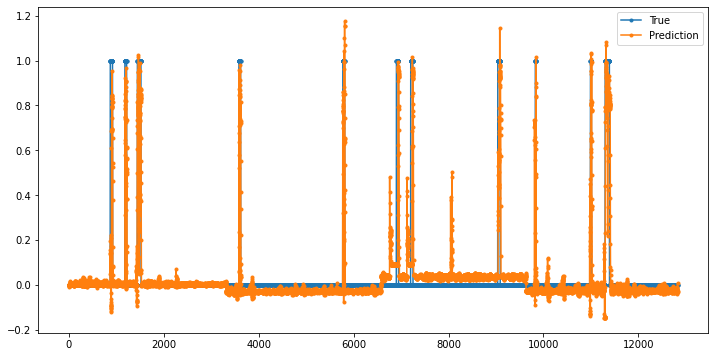

In [165]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv.flatten(), marker='.', label='True')
plt.plot(y_pred_inv, marker='.', label='Prediction')
plt.legend();

In [166]:
data = df.iloc[::-1]

In [167]:
range(len(y_pred_inv))

range(0, 12829)

In [168]:
y_pred_inv[4][0]

-0.0026452355

In [169]:
#Logic example to count number of falls
velocity = [3, 3, 3 ,3 ,3, 4, ... ,2 ,1, 0, 0, 0, 0] # velocity of a person walking and then falling
almost_fall_count=0
fall_count=0
for j in range(len(y_pred_inv)): #range(0, num of samples)
  for i in range(0,200): # last 200 samples (i.e [-i:])
    if y_pred_inv[-i:][0] > 0.9 and y_pred_inv[i][0] < 1.1: # if classified almost_fall
      almost_fall_count = almost_fall_count+1
    if almost_fall_count > 0 and velocity[j+200] == 0:
      fall_count = fall_count+1
      almost_fall_count = 0 # resetting if condition